## 第1步：实现核心算法
- 包括盒子生成、两种搜索策略

In [10]:
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(42)
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def generate_boxes(N: int) -> np.ndarray:
    """生成随机排列的盒子"""
    return np.random.permutation(N)

def random_search(boxes: np.ndarray, prisoner: int, K: int) -> bool:
    """随机搜索策略"""
    N = len(boxes)
    chosen_boxes = np.random.choice(N, K, replace=False)
    return prisoner in boxes[chosen_boxes]

def cycle_search(boxes: np.ndarray, prisoner: int, K: int) -> Tuple[bool, int]:
    """循环策略搜索"""
    current_box = prisoner
    for attempt in range(K):
        if boxes[current_box] == prisoner:
            return True, attempt + 1
        current_box = boxes[current_box]
    return False, K


## 第2步：输入参数与单次实验模拟

In [11]:
import pandas as pd
from tqdm import tqdm

def run_single_experiment(N: int, K: int, strategy: str) -> Tuple[bool, int, List[int]]:
    """运行单次实验
    
    Returns:
        (是否全体成功, 成功的囚犯数量, 每个囚犯的尝试次数列表)
    """
    boxes = generate_boxes(N)
    search_func = random_search if strategy == 'random' else cycle_search
    
    success_count = 0
    attempt_counts = []
    
    for prisoner in range(N):
        if strategy == 'random':
            success = search_func(boxes, prisoner, K)
            attempt_counts.append(K if not success else None)  # 随机策略不记录具体尝试次数
            if success:
                success_count += 1
        else:
            success, attempts = search_func(boxes, prisoner, K)
            attempt_counts.append(attempts)
            if success:
                success_count += 1
            
    return success_count == N, success_count, attempt_counts

def run_batch_experiments_random(N: int, K: int, batch_size: int) -> np.ndarray:
    """使用向量化方法运行一批随机策略实验
    
    Args:
        N: 囚犯数量
        K: 尝试次数
        batch_size: 批次大小
        
    Returns:
        每个囚犯是否成功的布尔数组 (batch_size, N)
    """
    # 为每个实验生成随机盒子排列 (batch_size, N)
    boxes = np.array([np.random.permutation(N) for _ in range(batch_size)])
    
    # 为每个囚犯生成随机选择的盒子 (batch_size, N, K)
    chosen_boxes = np.array([np.random.choice(N, (N, K), replace=False) for _ in range(batch_size)])
    
    # 检查每个囚犯是否找到自己的编号
    success = np.zeros((batch_size, N), dtype=bool)
    for i in range(N):
        # 获取每个囚犯选择的盒子内容 (batch_size, K)
        box_contents = np.take_along_axis(boxes[:, None, :], chosen_boxes[:, i:i+1, :], axis=2)
        success[:, i] = np.any(box_contents == i, axis=2)
    
    return success

## 第3步：批量模拟实验

In [24]:
from datetime import datetime

def run_batch_experiments_cycle(N: int, K: int, batch_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """使用向量化方法运行一批循环策略实验"""
    # 为每个实验生成随机盒子排列 (batch_size, N)
    boxes = np.array([np.random.permutation(N) for _ in range(batch_size)])
    
    # 记录成功状态和尝试次数
    success = np.zeros((batch_size, N), dtype=bool)
    attempts = np.zeros((batch_size, N), dtype=int)
    
    # 为每个囚犯进行循环搜索
    current_boxes = np.tile(np.arange(N), (batch_size, 1))  # 初始盒子编号
    for attempt in range(K):
        # 检查当前盒子是否包含囚犯编号
        found = (np.take_along_axis(boxes, current_boxes, axis=1) == np.arange(N))
        
        # 更新首次成功的尝试次数
        not_yet_found = ~success
        attempts[not_yet_found & found] = attempt + 1
        
        # 更新成功状态
        success |= found
        
        # 更新当前盒子编号
        current_boxes = np.take_along_axis(boxes, current_boxes, axis=1)
    
    # 对未成功的设置最大尝试次数
    attempts[~success] = K
    
    return success, attempts


In [13]:
# 参数设置
N = 100
K = 50
T = 10000
batch_size = min(1000, T)

# 批量运行实验函数（定义）
def run_batch_experiments_random(N: int, K: int, batch_size: int) -> np.ndarray:
    """使用向量化方法运行一批随机策略实验"""
    # 为每个实验生成随机盒子排列 (batch_size, N)
    boxes = np.array([np.random.permutation(N) for _ in range(batch_size)])
    
    # 为每个囚犯和每个实验生成随机选择的盒子
    success = np.zeros((batch_size, N), dtype=bool)
    
    # 为每个实验的每个囚犯单独生成随机选择
    for i in range(batch_size):
        for prisoner in range(N):
            # 为当前囚犯随机选择K个不重复的盒子
            chosen = np.random.choice(N, K, replace=False)
            # 检查是否找到自己的编号
            success[i, prisoner] = prisoner in boxes[i, chosen]
    
    return success

def run_multiple_experiments_vectorized(N: int, K: int, T: int, strategy: str) -> Tuple[float, List[bool], pd.DataFrame]:
    """使用向量化方法运行多次实验"""
    results = []
    experiment_data = []
    all_attempts = []
    
    # 设置批处理大小
    batch_size = min(1000, T)  # 避免内存占用过大
    num_batches = (T + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc=f'{strategy} 策略实验进度'):
        current_batch_size = min(batch_size, T - batch * batch_size)
        
        if strategy == 'random':
            success_matrix = run_batch_experiments_random(N, K, current_batch_size)
            batch_attempts = np.full((current_batch_size, N), K)  # 随机策略不记录具体尝试次数
        else:
            success_matrix, batch_attempts = run_batch_experiments_cycle(N, K, current_batch_size)
        
        # 处理每个实验的结果
        for i in range(current_batch_size):
            success_count = np.sum(success_matrix[i])
            all_success = success_count == N
            results.append(all_success)
            
            if strategy == 'cycle':
                all_attempts.extend(batch_attempts[i][success_matrix[i]])
            
            experiment_data.append({
                '轮次': batch * batch_size + i + 1,
                '策略': strategy,
                '结果': '成功' if all_success else '失败',
                '成功囚犯数': success_count,
                '成功囚犯比例': success_count / N,
                '平均尝试次数': np.mean(batch_attempts[i]) if strategy == 'cycle' else None
            })
    
    success_rate = sum(results) / T
    return success_rate, results, pd.DataFrame(experiment_data), all_attempts


## 第4步：保存到Excel

In [14]:
def save_results_to_excel(random_df: pd.DataFrame, cycle_df: pd.DataFrame, 
                         random_rate: float, cycle_rate: float, 
                         N: int, K: int, T: int):
    """保存结果到Excel文件"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'prisoner_experiment_results_{timestamp}.xlsx'
    
    # 计算统计信息
    random_stats = {
        '平均成功囚犯数': random_df['成功囚犯数'].mean(),
        '最少成功囚犯数': random_df['成功囚犯数'].min(),
        '最多成功囚犯数': random_df['成功囚犯数'].max(),
        '平均成功囚犯比例': random_df['成功囚犯比例'].mean(),
        '全体存活概率': random_rate
    }
    
    cycle_stats = {
        '平均成功囚犯数': cycle_df['成功囚犯数'].mean(),
        '最少成功囚犯数': cycle_df['成功囚犯数'].min(),
        '最多成功囚犯数': cycle_df['成功囚犯数'].max(),
        '平均成功囚犯比例': cycle_df['成功囚犯比例'].mean(),
        '全体存活概率': cycle_rate
    }
    
    # 创建Excel写入器
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # 保存实验参数
        params_df = pd.DataFrame({
            '参数': ['囚犯数量(N)', '尝试次数(K)', '实验轮次(T)'],
            '值': [N, K, T]
        })
        params_df.to_excel(writer, sheet_name='实验参数', index=False)
        
        # 保存随机策略结果
        random_df.to_excel(writer, sheet_name='随机策略结果', index=False)
        
        # 保存循环策略结果
        cycle_df.to_excel(writer, sheet_name='循环策略结果', index=False)
        
        # 保存统计信息
        stats_df = pd.DataFrame({
            '统计指标': list(random_stats.keys()),
            '随机策略': [f'{v:.4f}' if isinstance(v, float) else v for v in random_stats.values()],
            '循环策略': [f'{v:.4f}' if isinstance(v, float) else v for v in cycle_stats.values()]
        })
        stats_df.to_excel(writer, sheet_name='统计分析', index=False)
    
    return filename

## 第5步：获取输入

In [15]:
def get_user_input() -> Tuple[int, int, int]:
    """获取用户输入的参数
    
    Returns:
        (N: 囚犯数量, K: 尝试次数, T: 模拟轮次)
    """
    while True:
        try:
            N = input("请输入囚犯数量N（直接回车使用默认值100）: ").strip()
            N = 100 if N == "" else int(N)
            if N <= 0:
                print("囚犯数量必须大于0，请重新输入")
                continue
                
            K = input(f"请输入尝试次数K（直接回车使用默认值50）: ").strip()
            K = 50 if K == "" else int(K)
            if K <= 0 or K > N:
                print(f"尝试次数必须大于0且不大于囚犯数量{N}，请重新输入")
                continue
                
            T = input("请输入模拟轮次T（直接回车使用默认值10000）: ").strip()
            T = 10000 if T == "" else int(T)
            if T <= 0:
                print("模拟轮次必须大于0，请重新输入")
                continue
                
            return N, K, T
            
        except ValueError:
            print("输入格式错误，请输入整数或直接回车使用默认值")

## 第6步：执行实验

In [16]:
# 获取用户输入的参数
N, K, T = get_user_input()

print(f"\n使用参数：N={N}, K={K}, T={T}")
print("\n开始运行实验...\n")

# 运行两种策略的实验（使用向量化版本）
random_rate, random_results, random_df, _ = run_multiple_experiments_vectorized(N, K, T, 'random')
cycle_rate, cycle_results, cycle_df, cycle_attempts = run_multiple_experiments_vectorized(N, K, T, 'cycle')

# 保存结果到Excel
filename = save_results_to_excel(random_df, cycle_df, random_rate, cycle_rate, N, K, T)
print(f"\n实验结果已保存到文件：{filename}")

# 显示简要统计结果
print(f"\n实验结果总统计：")
print(f"随机策略：")
print(f"  - 全体存活概率: {random_rate:.4%}")
print(f"  - 平均成功囚犯数: {random_df['成功囚犯数'].mean():.2f}")
print(f"循环策略：")
print(f"  - 全体存活概率: {cycle_rate:.4%}")
print(f"  - 平均成功囚犯数: {cycle_df['成功囚犯数'].mean():.2f}")
print(f"  - 平均尝试次数: {np.mean(cycle_attempts):.2f}")
print(f"  - 最少尝试次数: {np.min(cycle_attempts)}")
print(f"  - 最多尝试次数: {np.max(cycle_attempts)}")
print(f"  - 尝试次数中位数: {np.median(cycle_attempts):.2f}")
print(f"\n策略成功率差异: {abs(cycle_rate - random_rate):.4%}")


使用参数：N=100, K=50, T=10000

开始运行实验...



cycle 策略实验进度: 100%|██████████| 10/10 [00:00<00:00, 12.85it/s]



实验结果已保存到文件：prisoner_experiment_results_20250526_103908.xlsx

实验结果总统计：
随机策略：
  - 全体存活概率: 0.0000%
  - 平均成功囚犯数: 50.03
循环策略：
  - 全体存活概率: 30.1200%
  - 平均成功囚犯数: 49.18
  - 平均尝试次数: 25.34
  - 最少尝试次数: 1
  - 最多尝试次数: 50
  - 尝试次数中位数: 25.00

策略成功率差异: 30.1200%


## 第7步：画分析图

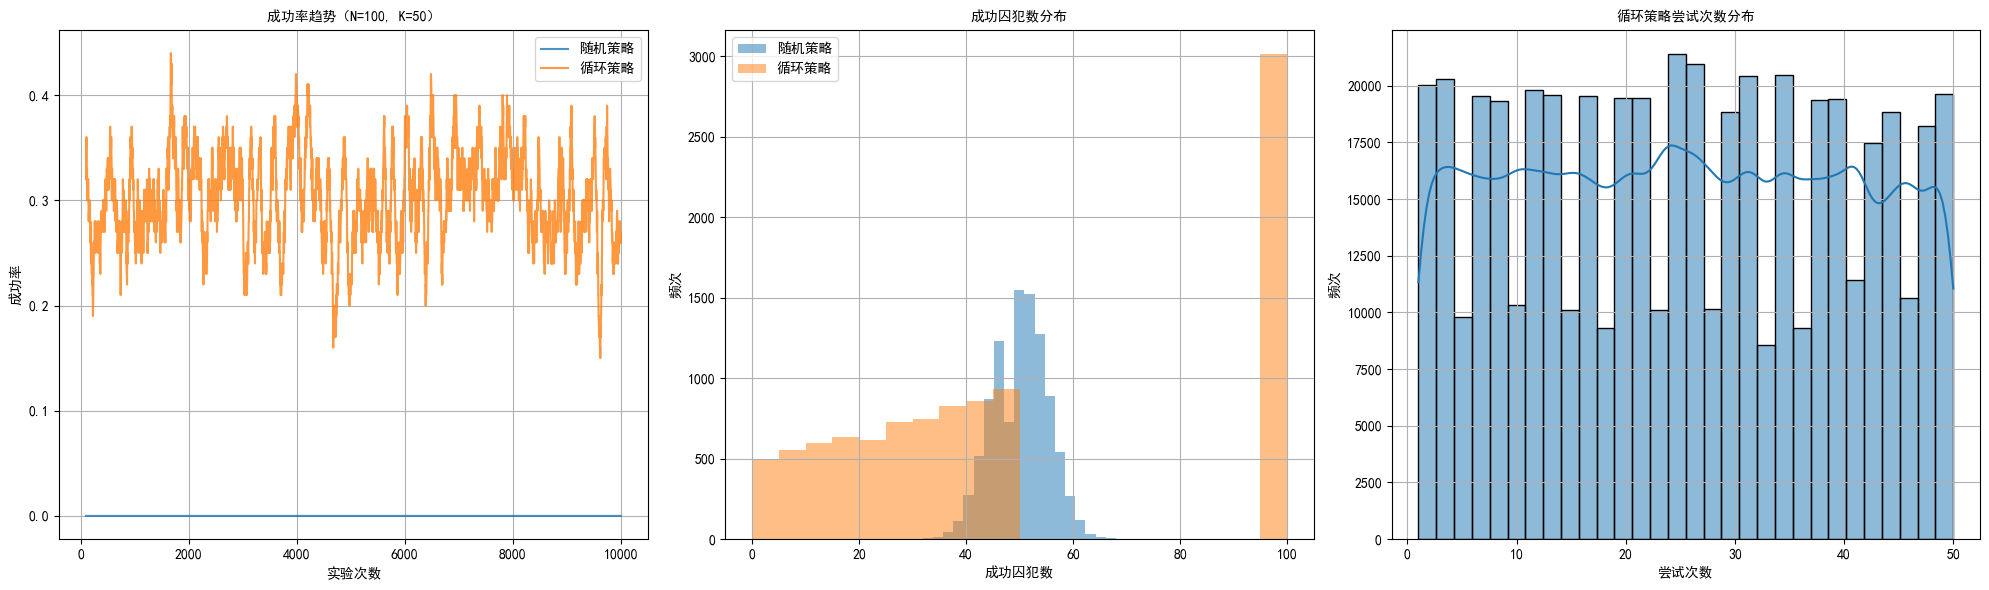

In [18]:
import seaborn as sns
# 创建三个子图的分析图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 重新设置字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 成功率趋势图
window = min(100, T//100)
random_ma = pd.Series(random_results).rolling(window).mean()
cycle_ma = pd.Series(cycle_results).rolling(window).mean()

ax1.plot(random_ma, label='随机策略', alpha=0.8)
ax1.plot(cycle_ma, label='循环策略', alpha=0.8)
ax1.set_title(f'成功率趋势（N={N}, K={K}）', fontproperties='SimHei')
ax1.set_xlabel('实验次数', fontproperties='SimHei')
ax1.set_ylabel('成功率', fontproperties='SimHei')
ax1.legend(prop={'family': 'SimHei'})
ax1.grid(True)

# 2. 成功囚犯数分布图
ax2.hist(random_df['成功囚犯数'], alpha=0.5, label='随机策略', bins=20)
ax2.hist(cycle_df['成功囚犯数'], alpha=0.5, label='循环策略', bins=20)
ax2.set_title('成功囚犯数分布', fontproperties='SimHei')
ax2.set_xlabel('成功囚犯数', fontproperties='SimHei')
ax2.set_ylabel('频次', fontproperties='SimHei')
ax2.legend(prop={'family': 'SimHei'})
ax2.grid(True)

# 3. 循环策略尝试次数分布图
sns.histplot(data=cycle_attempts, bins=30, ax=ax3, kde=True)
ax3.set_title('循环策略尝试次数分布', fontproperties='SimHei')
ax3.set_xlabel('尝试次数', fontproperties='SimHei')
ax3.set_ylabel('频次', fontproperties='SimHei')
ax3.grid(True)

plt.tight_layout()
plt.savefig(f'experiment_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
# plt.close()
plt.show()

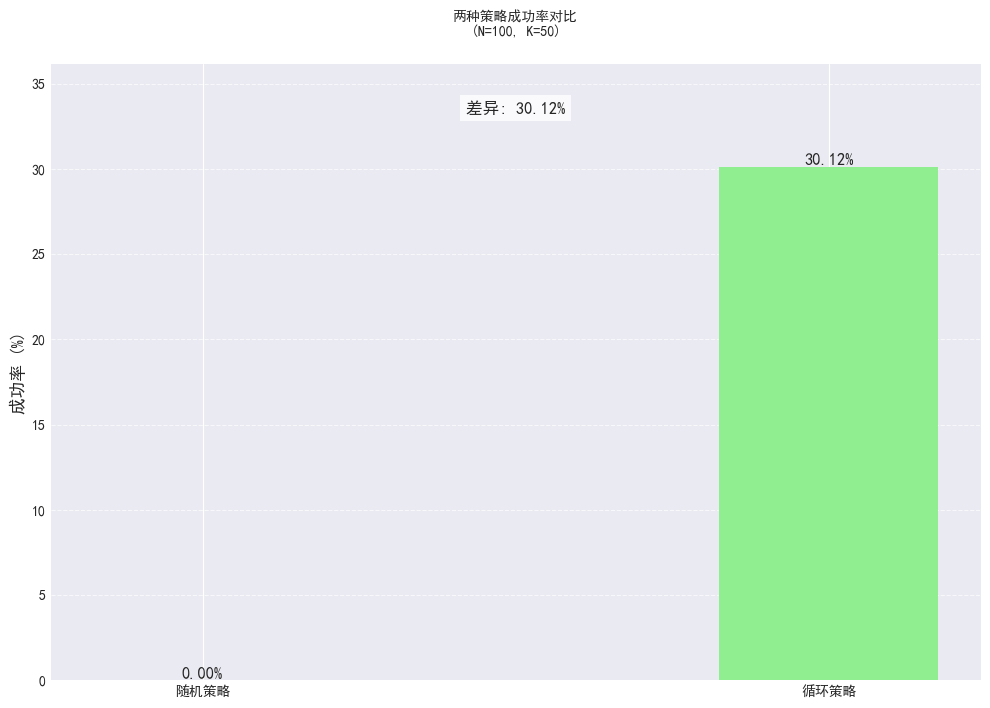

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
def plot_strategy_comparison(random_df: pd.DataFrame, cycle_df: pd.DataFrame, N: int, K: int):
    """创建策略对比可视化图"""
    # 设置绘图风格
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # 重新设置字体，因为style.use可能会覆盖之前的设置
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.figure(figsize=(12, 8))
    
    # 创建并排的柱状图
    x = np.arange(2)
    width = 0.35
    
    # 计算成功率统计
    random_success_rate = (random_df['结果'] == '成功').mean() * 100
    cycle_success_rate = (cycle_df['结果'] == '成功').mean() * 100
    
    # 绘制柱状图
    bars = plt.bar(x, [random_success_rate, cycle_success_rate], width,
                  color=['lightcoral', 'lightgreen'])
    
    # 添加标题和标签
    plt.title(f'两种策略成功率对比\n(N={N}, K={K})', fontsize=14, pad=20, fontproperties='SimHei')
    plt.xticks(x, ['随机策略', '循环策略'], fontsize=12, fontproperties='SimHei')
    plt.ylabel('成功率 (%)', fontsize=12, fontproperties='SimHei')
    
    # 在柱子上方添加具体数值
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=12)
    
    # 添加网格线
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 设置y轴范围，让图表更美观
    plt.ylim(0, max(random_success_rate, cycle_success_rate) * 1.2)
    
    # 添加成功率差异标注
    diff = abs(cycle_success_rate - random_success_rate)
    plt.text(0.5, max(random_success_rate, cycle_success_rate) * 1.1,
             f'差异: {diff:.2f}%',
             ha='center', va='bottom', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
             fontproperties='SimHei')
    
    # 保存图表
    plt.savefig('compare.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_strategy_comparison(random_df, cycle_df, N, K)

## 模拟并可视化循环策略成功囚犯数分布

循环策略模拟中: 100%|██████████| 10/10 [00:00<00:00, 17.11it/s]


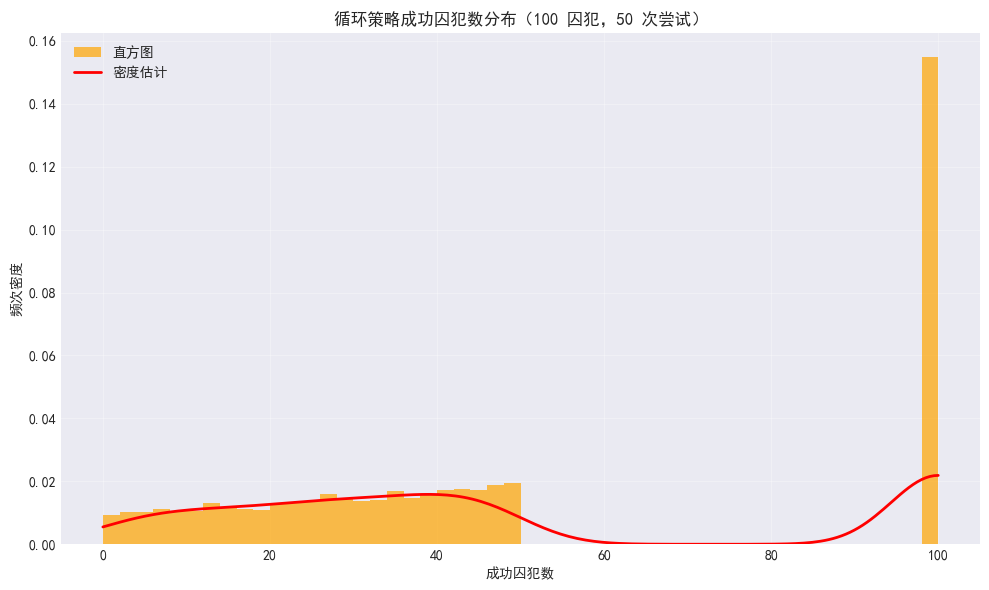

统计信息：
平均成功人数：49.86
成功人数中位数：39.00
成功人数标准差：35.62
最少成功人数：0
最多成功人数：100


In [26]:
# 保证中文和负号正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 若本地没有可替换为 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

# 模拟指定轮次数并统计每轮成功人数
def simulate_success_distribution(N: int = 100, K: int = 50, T: int = 10000) -> np.ndarray:
    batch_size = min(1000, T)
    num_batches = (T + batch_size - 1) // batch_size
    success_counts = []

    for batch in tqdm(range(num_batches), desc="循环策略模拟中"):
        size = min(batch_size, T - batch * batch_size)
        success_matrix, _ = run_batch_experiments_cycle(N, K, size)  # 注意这里添加了解包
        success_per_experiment = np.sum(success_matrix, axis=1)
        success_counts.extend(success_per_experiment)

    return np.array(success_counts)

# 执行模拟并绘图
success_counts = simulate_success_distribution(N=100, K=50, T=10000)

plt.figure(figsize=(10, 6))

# 绘制直方图
n, bins, patches = plt.hist(success_counts, bins=50, density=True, alpha=0.7, color='orange', 
                          label='直方图')

# 添加核密度估计曲线
from scipy import stats
kde = stats.gaussian_kde(success_counts)
x_range = np.linspace(success_counts.min(), success_counts.max(), 200)
plt.plot(x_range, kde(x_range), 'r-', lw=2, label='密度估计')

plt.title("循环策略成功囚犯数分布（100 囚犯，50 次尝试）")
plt.xlabel("成功囚犯数")
plt.ylabel("频次密度")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 输出一些基本统计信息
print(f"统计信息：")
print(f"平均成功人数：{np.mean(success_counts):.2f}")
print(f"成功人数中位数：{np.median(success_counts):.2f}")
print(f"成功人数标准差：{np.std(success_counts):.2f}")
print(f"最少成功人数：{np.min(success_counts)}")
print(f"最多成功人数：{np.max(success_counts)}")

## 实验：不同 N 和 K 下，随机策略成功率变化

N=50, K=25 → 全体成功率: 0.0000%
N=60, K=30 → 全体成功率: 0.0000%
N=70, K=35 → 全体成功率: 0.0000%
N=80, K=40 → 全体成功率: 0.0000%
N=90, K=45 → 全体成功率: 0.0000%
N=100, K=50 → 全体成功率: 0.0000%
N=120, K=60 → 全体成功率: 0.0000%
N=150, K=75 → 全体成功率: 0.0000%


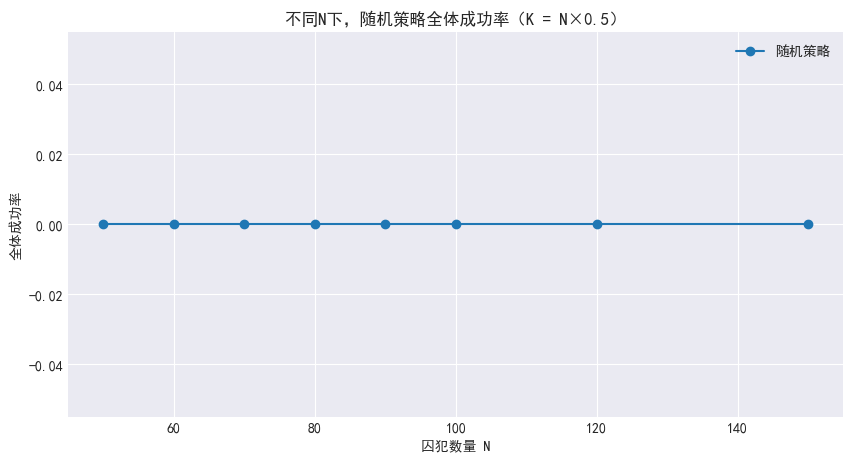

In [21]:
def evaluate_random_success_rates(N_values, K_ratio, T=5000):
    results = []
    for N in N_values:
        K = int(N * K_ratio)
        success_matrix = run_batch_experiments_random(N, K, T)
        full_success_rate = np.mean(np.sum(success_matrix, axis=1) == N)
        results.append((N, K, full_success_rate))
        print(f"N={N}, K={K} → 全体成功率: {full_success_rate:.4%}")
    return results

# 参数设置与实验
N_values = [50, 60, 70, 80, 90, 100, 120, 150]
K_ratio = 0.5  # K = N的一半
random_results = evaluate_random_success_rates(N_values, K_ratio)

# 可视化
Ns, Ks, rates = zip(*random_results)
plt.figure(figsize=(10, 5))
plt.plot(Ns, rates, marker='o', label='随机策略')
plt.title("不同N下，随机策略全体成功率（K = N×0.5）")
plt.xlabel("囚犯数量 N")
plt.ylabel("全体成功率")
plt.grid(True)
plt.legend()
plt.show()


## 实验：不同 N 和 K 下，循环策略成功率变化

N=50, K=25 → 全体成功率: 32.2200%
N=100, K=50 → 全体成功率: 30.1200%
N=150, K=75 → 全体成功率: 32.1800%
N=200, K=100 → 全体成功率: 31.3600%
N=250, K=125 → 全体成功率: 30.9400%
N=300, K=150 → 全体成功率: 30.7400%


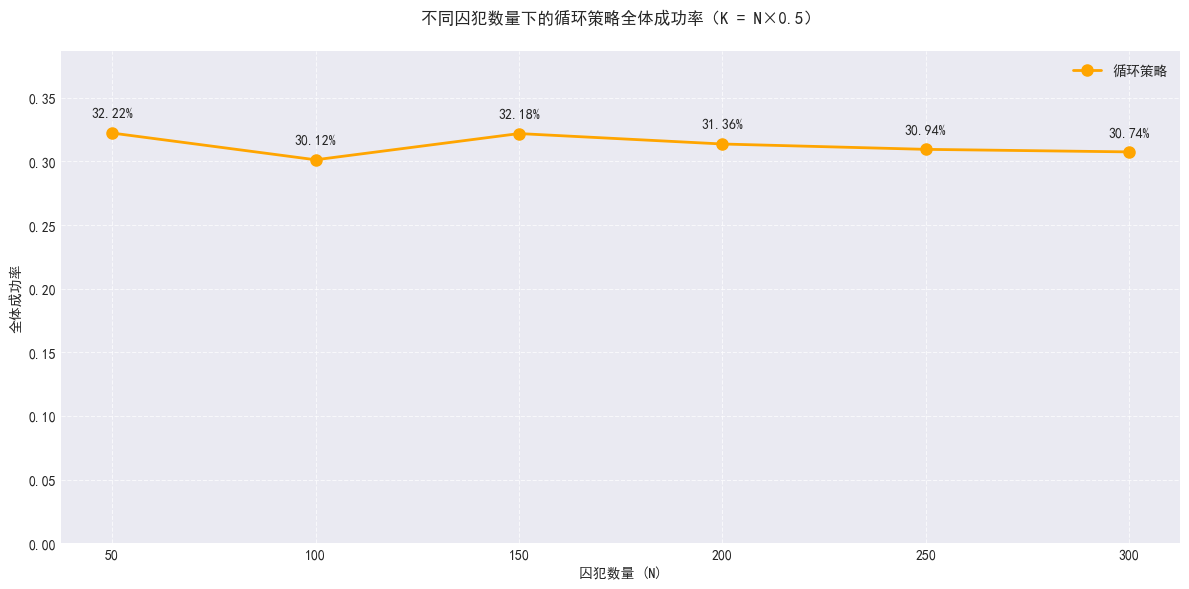


详细实验结果：
N=50, K=25: 全体成功率 = 32.2200%
N=100, K=50: 全体成功率 = 30.1200%
N=150, K=75: 全体成功率 = 32.1800%
N=200, K=100: 全体成功率 = 31.3600%
N=250, K=125: 全体成功率 = 30.9400%
N=300, K=150: 全体成功率 = 30.7400%


In [29]:
def evaluate_cycle_success_rates(N_values, K_ratio, T=5000):
    results = []
    for N in N_values:
        K = int(N * K_ratio)
        # 正确解包返回值
        success_matrix, _ = run_batch_experiments_cycle(N, K, T)
        full_success_rate = np.mean(np.sum(success_matrix, axis=1) == N)
        results.append((N, K, full_success_rate))
        print(f"N={N}, K={K} → 全体成功率: {full_success_rate:.4%}")
    return results

# 定义实验参数
N_values = np.array([50, 100, 150, 200, 250, 300])  # 不同的囚犯数量
K_ratio = 0.5  # K = N/2

# 运行实验
cycle_results = evaluate_cycle_success_rates(N_values, K_ratio)

# 可视化
plt.figure(figsize=(12, 6))
Ns, Ks, rates = zip(*cycle_results)

# 绘制折线图
plt.plot(Ns, rates, marker='o', color='orange', linewidth=2, markersize=8, label='循环策略')

# 添加数据标签
for N, rate in zip(Ns, rates):
    plt.annotate(f'{rate:.2%}', 
                xy=(N, rate), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                va='bottom')

plt.title("不同囚犯数量下的循环策略全体成功率（K = N×0.5）", pad=20)
plt.xlabel("囚犯数量 (N)")
plt.ylabel("全体成功率")
plt.grid(True, alpha=0.3)
plt.legend()

# 设置y轴范围，使图表更清晰
plt.ylim(0, max(rates) * 1.2)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 输出详细结果
print("\n详细实验结果：")
for N, K, rate in cycle_results:
    print(f"N={N}, K={K}: 全体成功率 = {rate:.4%}")